In [1]:

# ----------------------------------
# 1. Install Dependencies
# ----------------------------------

# Install Kaggle API and hmmlearn
!pip install kaggle hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 2.9 MB/s eta 0:00:00


In [2]:

# ----------------------------------
# 2. Set Up Kaggle API and Download Dataset
# ----------------------------------

# Upload kaggle.json (run this cell, then upload the file when prompted)
from google.colab import files
files.upload()  # Upload kaggle.json

# Set up Kaggle API credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the ESA-ADB Challenge dataset
!kaggle competitions download -c esa-adb-challenge

# Unzip the dataset
!unzip esa-adb-challenge.zip -d esa_adb_challenge

# List the downloaded files
!ls esa_adb_challenge

Saving kaggle.json to kaggle.json
Archive:  esa-adb-challenge.zip
  inflating: esa_adb_challenge/sample_submission.parquet  
  inflating: esa_adb_challenge/target_channels.csv  
  inflating: esa_adb_challenge/test.parquet  
  inflating: esa_adb_challenge/train.parquet  
sample_submission.parquet  target_channels.csv	test.parquet  train.parquet


In [3]:
# ----------------------------------
# 3. Import Libraries
# ----------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from hmmlearn.hmm import GaussianHMM
import os

# Set random seed for reproducibility
np.random.seed(42)


Target Channels Loaded: ['channel_12', 'channel_13', 'channel_14', 'channel_15', 'channel_16'] ... (total: 58 )

Training Data Shape: (14728321, 89)
Test Data Shape: (521280, 88)
Target Channels: 58 channels
Sample Submission Shape: (521280, 2)

Training Data Head:
   id  channel_1  channel_10  channel_11  channel_12  channel_13  channel_14  \
0   0    0.13791         0.0         0.0    0.317175    0.371764    0.297205   
1   1    0.13791         0.0         0.0    0.317175    0.371764    0.297205   
2   2    0.13791         0.0         0.0    0.317175    0.371764    0.297205   
3   3    0.13791         0.0         0.0    0.317175    0.371764    0.297205   
4   4    0.13791         0.0         0.0    0.317175    0.371764    0.297205   

   channel_15  channel_16  channel_17  ...  telecommand_351  telecommand_352  \
0    0.130113    0.766769    0.349474  ...              0.0              0.0   
1    0.130113    0.766769    0.349474  ...              0.0              0.0   
2    0.130113

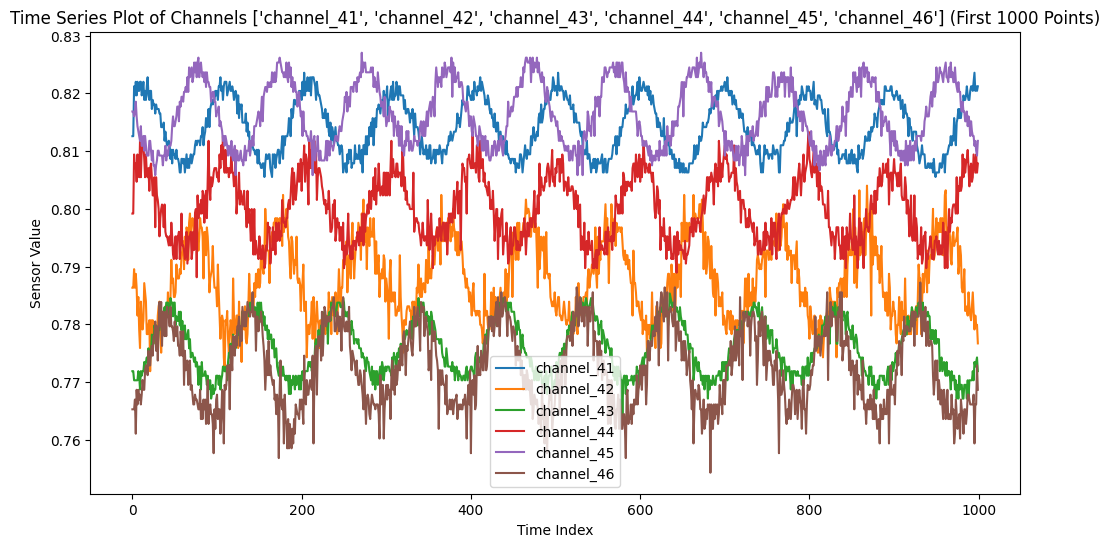

In [4]:
# ----------------------------------
# 4. Load and Explore the Data
# ----------------------------------

# Define file paths (Colab environment)
data_dir = "esa_adb_challenge"
train_file = os.path.join(data_dir, "train.parquet")
test_file = os.path.join(data_dir, "test.parquet")
target_channels_file = os.path.join(data_dir, "target_channels.csv")
submission_file = os.path.join(data_dir, "sample_submission.parquet")

# Load target channels
target_channels_df = pd.read_csv(target_channels_file)
target_channels = target_channels_df["target_channels"].tolist()  # Use correct column name
print("Target Channels Loaded:", target_channels[:5], "... (total:", len(target_channels), ")")

# Load other data
train_df = pd.read_parquet(train_file)
test_df = pd.read_parquet(test_file)
sample_submission = pd.read_parquet(submission_file)

# Display basic info
print("\nTraining Data Shape:", train_df.shape)
print("Test Data Shape:", test_df.shape)
print("Target Channels:", len(target_channels), "channels")
print("Sample Submission Shape:", sample_submission.shape)

# Preview training data
print("\nTraining Data Head:")
print(train_df.head())

# Check anomaly distribution
print("\nAnomaly Distribution in Training Data:")
print(train_df["is_anomaly"].value_counts(normalize=True))

# Verify is_anomaly is binary
print("\nUnique values in is_anomaly:", np.unique(train_df["is_anomaly"]))

# Visualize a subset of channels (41–46 recommended, if available)
subset_channels = [ch for ch in target_channels if ch in [f"channel_{i}" for i in range(41, 47)]]
if not subset_channels:
    print("Warning: Channels 41–46 not found in target_channels. Using first 6 target channels instead.")
    subset_channels = target_channels[:6]
plt.figure(figsize=(12, 6))
for channel in subset_channels:
    plt.plot(train_df.index[:1000], train_df[channel][:1000], label=channel)
plt.title(f"Time Series Plot of Channels {subset_channels} (First 1000 Points)")
plt.xlabel("Time Index")
plt.ylabel("Sensor Value")
plt.legend()
plt.show()



In [5]:

# ----------------------------------
# 5. Preprocess the Data
# ----------------------------------

# Select features (start with subset channels, then scale to all target channels)
features = subset_channels  # Replace with target_channels for full model
X_train = train_df[features].values
X_test = test_df[features].values
y_train = train_df["is_anomaly"].values

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Split training data into train/validation (e.g., 80% train, 20% validation)
train_size = int(0.8 * len(X_train_scaled))
X_train_split = X_train_scaled[:train_size]
y_train_split = y_train[:train_size]
X_val_split = X_train_scaled[train_size:]
y_val_split = y_train[train_size:]

print("Training Split Shape:", X_train_split.shape)
print("Validation Split Shape:", X_val_split.shape)


Training Split Shape: (11782656, 6)
Validation Split Shape: (2945665, 6)


In [13]:
# ----------------------------------
# 5. Preprocess the Data
# ----------------------------------

# Select features (start with subset channels)
features = subset_channels
lag = 5  # Add 5 lags for each channel
for channel in subset_channels:
    for l in range(1, lag + 1):
        train_df[f"{channel}_lag_{l}"] = train_df[channel].shift(l)
        test_df[f"{channel}_lag_{l}"] = test_df[channel].shift(l)
features += [f"{ch}_lag_{l}" for ch in subset_channels for l in range(1, lag + 1)]

# Handle missing values
train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)

X_train = train_df[features].values
X_test = test_df[features].values
y_train = train_df["is_anomaly"].values

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Split training data into train/validation (80% train, 20% validation)
train_size = int(0.8 * len(X_train_scaled))
X_train_split = X_train_scaled[:train_size]
y_train_split = y_train[:train_size]
X_val_split = X_train_scaled[train_size:]
y_val_split = y_train[train_size:]

print("Training Split Shape:", X_train_split.shape)
print("Validation Split Shape:", X_val_split.shape)

Training Split Shape: (11782656, 36)
Validation Split Shape: (2945665, 36)


In [21]:
# ----------------------------------
# 6. Train Gaussian Mixture Model (PGM Approach)
# ----------------------------------

import time
from sklearn.mixture import GaussianMixture

# Train GMM on normal data (is_anomaly == 0)
print("Filtering normal data (is_anomaly == 0)...")
normal_indices = np.where(y_train_split == 0)[0]
X_train_normal = X_train_split[normal_indices]
print(f"X_train_normal Shape: {X_train_normal.shape}")
print(f"Number of normal samples: {len(normal_indices)}")
print(f"Sample data (first 5 rows): \n{X_train_normal[:5]}")

# Initialize GMM
print("\nInitializing GaussianMixture...")
print(f"Parameters: n_components=2, random_state=42")
gmm = GaussianMixture(n_components=2, random_state=42, n_init=1, max_iter=100)

# Train GMM with timing
print("\nStarting GMM training...")
start_time = time.time()
gmm.fit(X_train_normal)
end_time = time.time()
print(f"GMM training completed in {end_time - start_time:.2f} seconds!")

# Compute anomaly scores for validation set (negative log-likelihoods)
print("\nComputing anomaly scores for validation set...")
val_scores = -gmm.score_samples(X_val_split)  # Higher scores indicate anomalies
print(f"Anomaly Scores Shape (Validation): {val_scores.shape}")
print(f"Sample Anomaly Scores (Validation, first 5): {val_scores[:5]}")

# Determine anomaly threshold (5th percentile of normal data scores)
print("\nComputing anomaly scores for normal training data...")
normal_scores = -gmm.score_samples(X_train_normal)
threshold = np.percentile(normal_scores, 5)  # Adjust percentile as needed
print(f"Anomaly Threshold (5th percentile): {threshold}")

# Predict anomalies on validation set
print("\nPredicting anomalies on validation set...")
val_predictions = (val_scores > threshold).astype(int)  # Higher scores are anomalies
print(f"Predictions Shape (Validation): {val_predictions.shape}")
print(f"Unique values in val_predictions: {np.unique(val_predictions)}")
print(f"Number of predicted anomalies: {np.sum(val_predictions)}")

Filtering normal data (is_anomaly == 0)...
X_train_normal Shape: (10548727, 36)
Number of normal samples: 10548727
Sample data (first 5 rows): 
[[ 1.40185207e-01  1.36039749e-01  1.04274832e-01  1.49071738e-01
   2.05926031e-01 -1.07273413e-02 -2.59258518e+01 -2.59252605e+01
  -2.59246674e+01 -2.59240742e+01 -2.59234810e+01 -2.51957951e+01
  -2.51952515e+01 -2.51947060e+01 -2.51941605e+01 -2.51936169e+01
  -2.40613041e+01 -2.40608292e+01 -2.40603561e+01 -2.40598831e+01
  -2.40594082e+01 -2.29047298e+01 -2.29043217e+01 -2.29039116e+01
  -2.29035034e+01 -2.29030933e+01 -2.57748299e+01 -2.57742462e+01
  -2.57736626e+01 -2.57730808e+01 -2.57724972e+01 -2.50595741e+01
  -2.50590382e+01 -2.50585022e+01 -2.50579662e+01 -2.50574303e+01]
 [ 1.40185207e-01  1.36039749e-01  1.04274832e-01  1.49071738e-01
   2.05926031e-01 -1.07273413e-02  1.40183777e-01 -2.59252605e+01
  -2.59246674e+01 -2.59240742e+01 -2.59234810e+01  1.36038557e-01
  -2.51952515e+01 -2.51947060e+01 -2.51941605e+01 -2.51936169e+

y_val_split Shape: (2945665,)
Unique values in y_val_split: [0 1]

Validation Performance:
Precision: 0.1060
Recall: 0.9783
F1-Score: 0.1912


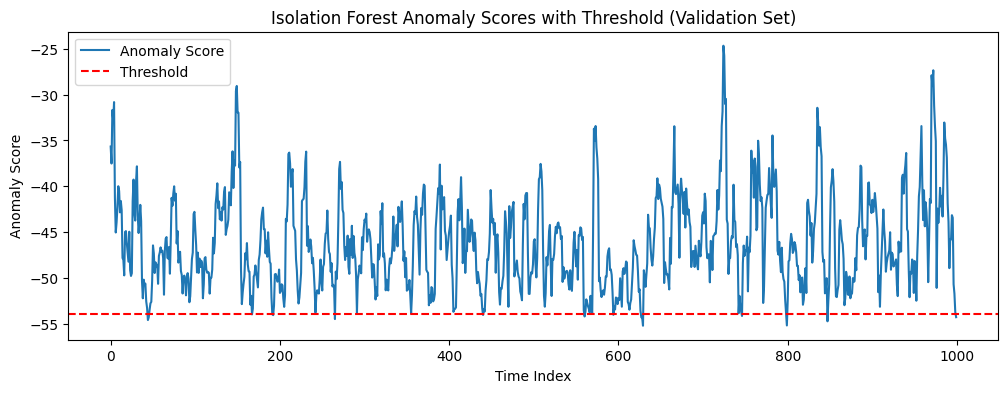

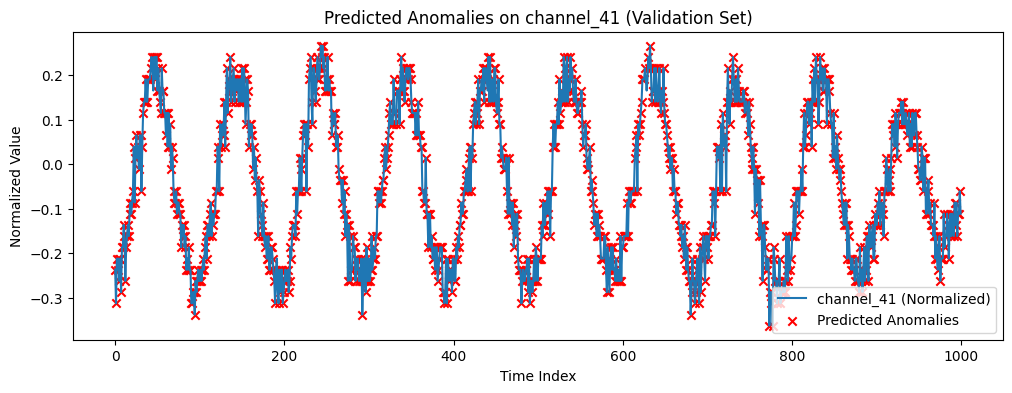

In [22]:
# ----------------------------------
# 7. Evaluate the Model
# ----------------------------------

# Ensure y_val_split and val_predictions are binary
print("y_val_split Shape:", y_val_split.shape)  # Should be (2945665,)
print("Unique values in y_val_split:", np.unique(y_val_split))  # Should be [0 1]

# Compute evaluation metrics
# Precision: TP / (TP + FP) - Minimize false positives
# Recall: TP / (TP + FN) - Maximize anomaly detection
# F1-Score: Balances precision and recall
precision = precision_score(y_val_split, val_predictions)
recall = recall_score(y_val_split, val_predictions)
f1 = f1_score(y_val_split, val_predictions)

print("\nValidation Performance:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Visualize anomaly scores on validation set (first 1000 points for clarity)
# Plots scores vs. time, with threshold line to show anomaly detection
plt.figure(figsize=(12, 4))
plt.plot(val_scores[:1000], label="Anomaly Score")
plt.axhline(threshold, color="r", linestyle="--", label="Threshold")
plt.title("Isolation Forest Anomaly Scores with Threshold (Validation Set)")
plt.xlabel("Time Index")
plt.ylabel("Anomaly Score")
plt.legend()
plt.show()

# Plot predicted anomalies on a single channel (e.g., channel_12)
# Shows time series with anomalies marked as red X’s
plt.figure(figsize=(12, 4))
plt.plot(X_val_split[:1000, 0], label=f"{subset_channels[0]} (Normalized)")
plt.scatter(np.where(val_predictions[:1000] == 1)[0], X_val_split[:1000, 0][val_predictions[:1000] == 1],
            color="red", label="Predicted Anomalies", marker="x")
plt.title(f"Predicted Anomalies on {subset_channels[0]} (Validation Set)")
plt.xlabel("Time Index")
plt.ylabel("Normalized Value")
plt.legend()
plt.show()

In [24]:
#----------------------------------
# 8. Generate Test Set Predictions
# ----------------------------------

print("\nComputing anomaly scores for test set...")
test_scores = -gmm.score_samples(X_test_scaled)
print(f"Test Scores Shape: {test_scores.shape}")
print(f"Sample Test Scores (first 5): {test_scores[:5]}")

test_predictions = (test_scores > threshold).astype(int)
print(f"Test Predictions Shape: {test_predictions.shape}")
print(f"Unique values in test_predictions: {np.unique(test_predictions)}")
print(f"Number of predicted anomalies: {np.sum(test_predictions)}")

submission_df = sample_submission.copy()
submission_df["is_anomaly"] = test_predictions
submission_df.to_parquet("submission.parquet")

print("\nSubmission File Prepared:")
print(submission_df.head())
files.download("submission.parquet")

# ----------------------------------
# 9. Optional: Scale to All Target Channels
# ----------------------------------
# Set features = target_channels in Section 5
# Use PCA if needed: pca = PCA(n_components=10); X_train_scaled = pca.fit_transform(X_train)

# ----------------------------------
# 10. Save Results for Presentation
# ----------------------------------

plt.figure(figsize=(8, 6))
plt.plot(val_scores[:1000], label="Anomaly Score (Neg Log-Likelihood)")
plt.axhline(threshold, color="r", linestyle="--", label="Threshold")
plt.title("GMM Anomaly Scores for Anomaly Detection")
plt.xlabel("Time Index")
plt.ylabel("Anomaly Score")
plt.legend()
plt.savefig("gmm_plot.png")
files.download("gmm_plot.png")
plt.close()

print("\nNotebook Complete! Submission and plot saved.")


Computing anomaly scores for test set...
Test Scores Shape: (521280,)
Sample Test Scores (first 5): [54128.69911837 51794.53516993 51782.96272037 51797.09111968
 51476.06631414]
Test Predictions Shape: (521280,)
Unique values in test_predictions: [0 1]
Number of predicted anomalies: 505358

Submission File Prepared:
         id  is_anomaly
0  14728321           1
1  14728322           1
2  14728323           1
3  14728324           1
4  14728325           1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Notebook Complete! Submission and plot saved.
